# Process Flow

* Importing the important modules required for data loading, data transformation, display, preprocessing and model creation
* Creating transformation for applying on images, to rescale the images
* Using datsets creating training and testing data
* Displaying some images from training and testing datasets
* Write a function that creates subsets of data as given in problem statement
* Writing train and evaluation funtions for training and evaluating the model performance on the Fashion MNIST dataset
* Creating an Alexnet like architecture
* Writing the function for training and evaluting the model
* Displaying the graph showing the accuracy change with changing training size

Consider we are going to cook a delicious dish named ***Paneer fashion MINST masala*** by no other then **Chef Tribhuvan**, for this first we would collect all the ingridients, so in initial steps we are collecting all the important ingredients for the delicious reciepe. In first step I took all the readymade spices availiable (important libraries) for our dish

In [ ]:
#importing important libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


Now obiously there are some ingredients that aren't readily availiable in market, so we need to buy some raw materials like onion and tomato and create a puri, same is the case here. We need to get the data and apply some transforms and prepare it in a way which we can cook.

Let's add onion and tomatoes to the mixer grinder


In [ ]:
def load_fashion_mnist_dataset(root: str = 'data') -> tuple:
    """
    Load FashionMNIST dataset for training and testing.

    Args:
        root (str): Root directory where the dataset will be saved.

    Returns:
        tuple: A tuple containing training and testing datasets.
            The datasets are instances of torchvision.datasets.FashionMNIST.
    """
    try:
        # Define the transforms for preprocessing the images
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # Download FashionMNIST training and testing datasets
        train_dataset = datasets.FashionMNIST(
            root=root,
            train=True,
            download=True,
            transform=transform
        )

        test_dataset = datasets.FashionMNIST(
            root=root,
            train=False,
            download=True,
            transform=transform
        )

        return train_dataset, test_dataset

    except Exception as e:
        print("An error occurred while loading the dataset:", str(e))
        return None, None


Let me open the mixer grinder and see how does my prepared ingridients looks like. Is it Okay? or I need to grind it more. lol

Let's plot some of the images from our training and testing datasets

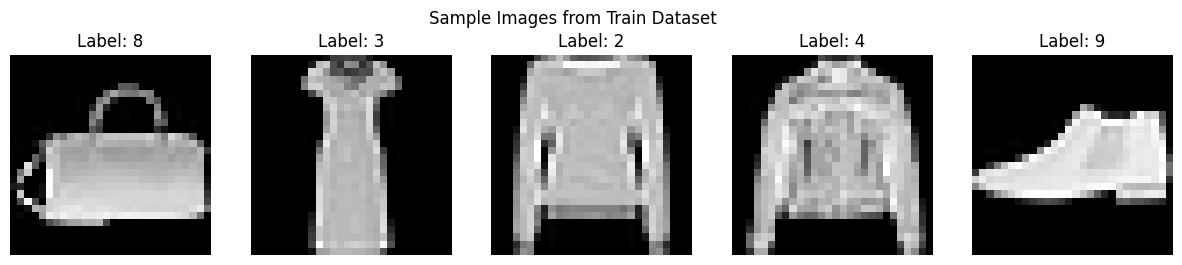

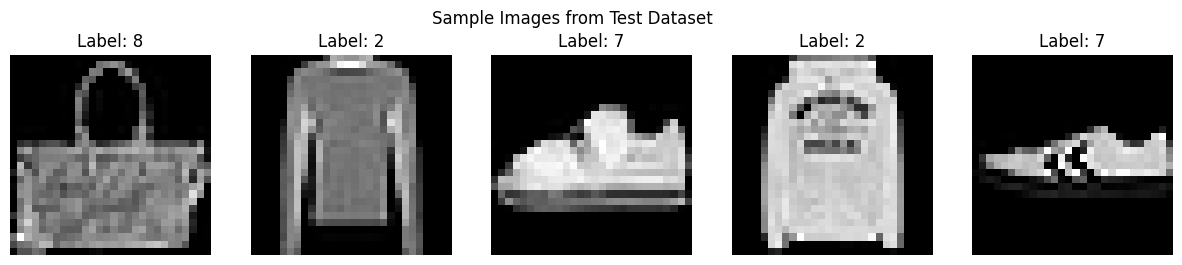

In [ ]:
def display_images_from_dataset(dataset, num_images=5, title='Sample Images'):
    """
    Display sample images from a dataset.

    Args:
        dataset (torch.utils.data.Dataset): Dataset containing images.
        num_images (int): Number of images to display (default is 5).
        title (str): Title of the plot (default is 'Sample Images').

    Returns:
        None
    """
    try:
        # Randomly select num_images indices
        indices = np.random.choice(len(dataset), size=num_images, replace=False)

        fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
        fig.suptitle(title)

        for i, idx in enumerate(indices):
            image, label = dataset[idx]

            axes[i].imshow(image.squeeze(), cmap='gray')
            axes[i].set_title(f'Label: {label}')
            axes[i].axis('off')

        plt.show()

    except Exception as e:
        print("An error occurred while displaying images:", str(e))


train_dataset, test_dataset = load_fashion_mnist_dataset(root='data')
display_images_from_dataset(train_dataset, num_images=5, title='Sample Images from Train Dataset')
display_images_from_dataset(test_dataset, num_images=5, title='Sample Images from Test Dataset')


I think I'm missing something very important, right?
What's it, it is paneer (model architecture), let's use the milk availiable in the house and make some paneer.

In this step we are implementing architecture of Alexnet which has gave good results for image classification tasks

In [ ]:
class AlexNet_FashionMNIST(nn.Module):
    """
    AlexNet like model architecture for classification.

    Args:
        num_classes (int): Number of classes in the classification task (default is 10).

    """

    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        """
        Forward pass of the AlexNet model.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, num_classes).
        """
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


We are all set with our ingridients, let's fix other stuff like for how much time we will cook, how much oil is required, how much salt is required.

More salt will destroy the taste and same is the case with less salt. We need to make a balance, here we are defining train_model and evaluate_model function because of gpu usage limitations, I will be running it for 10 epochs

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10) -> None:
    """
    Train the model.

    Args:
        model: The model to be trained.
        train_loader: DataLoader for the training dataset.
        criterion: The loss function.
        optimizer: The optimizer for updating model parameters.
        num_epochs (int): Number of epochs to train the model (default is 10).
    """
    try:
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(train_loader.dataset)
            print(f'Train Loss: {epoch_loss:.4f}')

    except Exception as e:
        print("An error occurred while training the model:", str(e))

def evaluate_model(model, test_loader) -> float:
    """
    Evaluate the model on the test set.

    Args:
        model: The model to be evaluated.
        test_loader: DataLoader for the test dataset.

    Returns:
        float: Accuracy of the model on the test set.
    """
    try:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        print(f'Test Accuracy: {accuracy:.4f}')
        return accuracy

    except Exception as e:
        print("An error occurred while evaluating the model:", str(e))
        return 0.0  # Return 0.0 as accuracy in case of error


Ohhhhppss!!! still something is left, very sorry I know you're hungry. Let's do it quickly, let's decide the amount of ingridients we will be using in our reciepe so that it tastes good

As given in the problem statement let's create some subsets for the task to observe the impact of training size on the model preformance.

In [ ]:
def sample_subsets(dataset, sizes: list) -> list:
    """
    Sample subsets of different sizes from a given dataset.

    Args:
        dataset: The dataset from which subsets will be sampled.
        sizes (list): List of proportions (floats) representing the sizes of subsets
            to be sampled. Each value should be between 0 and 1.

    Returns:
        list: A list containing subsets of the dataset.
            Each subset is a torch.utils.data.Subset object.
    """
    try:
        subsets = []
        for size in sizes:
            subset_size = int(len(dataset) * size)
            subset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size])
            subsets.append(subset)
        return subsets

    except Exception as e:
        print("An error occurred while sampling subsets:", str(e))
        return []


Let's see if it needs to be cooked on gas stove or induction

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Huray! We are ready to go now, let's put the pan on stove and start cooking our tasty ***Paneer Fashion MNIST masala***, here we gooo...

In [ ]:
def train_and_evaluate_on_subsets(train_dataset, test_dataset, subset_sizes, model, criterion, optimizer) -> list:
    """
    Train classifiers on subsets of training dataset and compute test accuracies.

    Args:
        train_dataset: The training dataset.
        test_dataset: The testing dataset.
        subset_sizes (list): List of subset sizes to be sampled.
        model: The model architecture to be used.
        criterion: The loss function.
        optimizer: The optimizer for updating model parameters.

    Returns:
        list: List of test accuracies obtained for each subset size.
    """
    accuracies = []
    try:
        for size in subset_sizes:
            subset = sample_subsets(train_dataset, [size])[0]
            train_loader = DataLoader(subset, batch_size=64, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

            model = model.to(device)

            train_model(model, train_loader, criterion, optimizer)
            accuracy = evaluate_model(model, test_loader)
            accuracies.append(accuracy)

        return accuracies

    except Exception as e:
        print("An error occurred during training and evaluation:", str(e))
        return []


Cooking has started, give it proper time to cook, here we are calling all the required functions and runnning our model on the image subsets

In [ ]:
train_dataset, test_dataset = load_fashion_mnist_dataset(root='data')

subset_sizes = np.linspace(0.001, 0.1, num=10)

model = AlexNet_FashionMNIST(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

accuracies = train_and_evaluate_on_subsets(train_dataset, test_dataset, subset_sizes, model, criterion, optimizer)
print("Test Accuracies for Different Subset Sizes:", accuracies)


100%|██████████| 26421880/26421880 [00:01<00:00, 16141498.80it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 307685.71it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5493137.77it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12510009.84it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Epoch 1/10: 100%|██████████| 1/1 [00:00<00:00,  1.82batch/s]


Train Loss: 2.2992


Epoch 2/10: 100%|██████████| 1/1 [00:00<00:00,  7.71batch/s]


Train Loss: 2.2848


Epoch 3/10: 100%|██████████| 1/1 [00:00<00:00,  8.71batch/s]


Train Loss: 2.2709


Epoch 4/10: 100%|██████████| 1/1 [00:00<00:00, 10.07batch/s]


Train Loss: 2.2498


Epoch 5/10: 100%|██████████| 1/1 [00:00<00:00,  7.64batch/s]


Train Loss: 2.2088


Epoch 6/10: 100%|██████████| 1/1 [00:00<00:00,  9.77batch/s]


Train Loss: 2.1808


Epoch 7/10: 100%|██████████| 1/1 [00:00<00:00, 10.87batch/s]


Train Loss: 2.1772


Epoch 8/10: 100%|██████████| 1/1 [00:00<00:00,  9.21batch/s]


Train Loss: 2.0983


Epoch 9/10: 100%|██████████| 1/1 [00:00<00:00,  9.70batch/s]


Train Loss: 2.0384


Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00, 10.40batch/s]


Train Loss: 1.9819
Test Accuracy: 0.3121


Epoch 1/10: 100%|██████████| 12/12 [00:01<00:00,  9.86batch/s]


Train Loss: 1.7495


Epoch 2/10: 100%|██████████| 12/12 [00:01<00:00, 10.30batch/s]


Train Loss: 1.3743


Epoch 3/10: 100%|██████████| 12/12 [00:01<00:00,  9.94batch/s]


Train Loss: 1.1086


Epoch 4/10: 100%|██████████| 12/12 [00:01<00:00, 10.24batch/s]


Train Loss: 1.0306


Epoch 5/10: 100%|██████████| 12/12 [00:01<00:00, 10.32batch/s]


Train Loss: 0.8922


Epoch 6/10: 100%|██████████| 12/12 [00:01<00:00, 10.09batch/s]


Train Loss: 0.8775


Epoch 7/10: 100%|██████████| 12/12 [00:01<00:00, 10.25batch/s]


Train Loss: 0.7922


Epoch 8/10: 100%|██████████| 12/12 [00:01<00:00,  9.48batch/s]


Train Loss: 0.7579


Epoch 9/10: 100%|██████████| 12/12 [00:01<00:00,  6.94batch/s]


Train Loss: 0.7027


Epoch 10/10: 100%|██████████| 12/12 [00:01<00:00,  8.34batch/s]


Train Loss: 0.7015
Test Accuracy: 0.7522


Epoch 1/10: 100%|██████████| 22/22 [00:02<00:00,  8.56batch/s]


Train Loss: 0.6708


Epoch 2/10: 100%|██████████| 22/22 [00:02<00:00,  7.66batch/s]


Train Loss: 0.6617


Epoch 3/10: 100%|██████████| 22/22 [00:02<00:00,  9.56batch/s]


Train Loss: 0.6258


Epoch 4/10: 100%|██████████| 22/22 [00:02<00:00,  9.59batch/s]


Train Loss: 0.5745


Epoch 5/10: 100%|██████████| 22/22 [00:02<00:00,  9.86batch/s]


Train Loss: 0.5684


Epoch 6/10: 100%|██████████| 22/22 [00:02<00:00,  9.11batch/s]


Train Loss: 0.5209


Epoch 7/10: 100%|██████████| 22/22 [00:04<00:00,  5.42batch/s]


Train Loss: 0.5150


Epoch 8/10: 100%|██████████| 22/22 [00:05<00:00,  4.16batch/s]


Train Loss: 0.4774


Epoch 9/10: 100%|██████████| 22/22 [00:03<00:00,  7.03batch/s]


Train Loss: 0.4614


Epoch 10/10: 100%|██████████| 22/22 [00:03<00:00,  7.08batch/s]


Train Loss: 0.4609
Test Accuracy: 0.8080


Epoch 1/10: 100%|██████████| 32/32 [00:03<00:00,  8.29batch/s]


Train Loss: 0.5833


Epoch 2/10: 100%|██████████| 32/32 [00:03<00:00,  8.88batch/s]


Train Loss: 0.5473


Epoch 3/10: 100%|██████████| 32/32 [00:03<00:00,  9.63batch/s]


Train Loss: 0.4987


Epoch 4/10: 100%|██████████| 32/32 [00:03<00:00,  9.68batch/s]


Train Loss: 0.4901


Epoch 5/10: 100%|██████████| 32/32 [00:04<00:00,  7.73batch/s]


Train Loss: 0.4802


Epoch 6/10: 100%|██████████| 32/32 [00:03<00:00,  9.61batch/s]


Train Loss: 0.4400


Epoch 7/10: 100%|██████████| 32/32 [00:03<00:00,  9.41batch/s]


Train Loss: 0.4370


Epoch 8/10: 100%|██████████| 32/32 [00:03<00:00,  8.59batch/s]


Train Loss: 0.4346


Epoch 9/10: 100%|██████████| 32/32 [00:03<00:00,  8.33batch/s]


Train Loss: 0.4081


Epoch 10/10: 100%|██████████| 32/32 [00:03<00:00,  9.38batch/s]


Train Loss: 0.3951
Test Accuracy: 0.8369


Epoch 1/10: 100%|██████████| 43/43 [00:04<00:00,  9.52batch/s]


Train Loss: 0.5218


Epoch 2/10: 100%|██████████| 43/43 [00:04<00:00,  9.10batch/s]


Train Loss: 0.4947


Epoch 3/10: 100%|██████████| 43/43 [00:05<00:00,  8.16batch/s]


Train Loss: 0.4739


Epoch 4/10: 100%|██████████| 43/43 [00:04<00:00,  9.40batch/s]


Train Loss: 0.4567


Epoch 5/10: 100%|██████████| 43/43 [00:05<00:00,  7.95batch/s]


Train Loss: 0.4254


Epoch 6/10: 100%|██████████| 43/43 [00:04<00:00,  9.48batch/s]


Train Loss: 0.4459


Epoch 7/10: 100%|██████████| 43/43 [00:04<00:00,  9.46batch/s]


Train Loss: 0.4002


Epoch 8/10: 100%|██████████| 43/43 [00:05<00:00,  8.02batch/s]


Train Loss: 0.3856


Epoch 9/10: 100%|██████████| 43/43 [00:04<00:00,  8.76batch/s]


Train Loss: 0.3820


Epoch 10/10: 100%|██████████| 43/43 [00:05<00:00,  7.88batch/s]


Train Loss: 0.3868
Test Accuracy: 0.8537


Epoch 1/10: 100%|██████████| 53/53 [00:06<00:00,  8.15batch/s]


Train Loss: 0.4477


Epoch 2/10: 100%|██████████| 53/53 [00:05<00:00,  9.60batch/s]


Train Loss: 0.4156


Epoch 3/10: 100%|██████████| 53/53 [00:06<00:00,  7.98batch/s]


Train Loss: 0.3959


Epoch 4/10: 100%|██████████| 53/53 [00:08<00:00,  6.57batch/s]


Train Loss: 0.3666


Epoch 5/10: 100%|██████████| 53/53 [00:06<00:00,  8.30batch/s]


Train Loss: 0.3583


Epoch 6/10: 100%|██████████| 53/53 [00:06<00:00,  8.52batch/s]


Train Loss: 0.3516


Epoch 7/10: 100%|██████████| 53/53 [00:10<00:00,  4.83batch/s]


Train Loss: 0.3299


Epoch 8/10: 100%|██████████| 53/53 [00:06<00:00,  8.45batch/s]


Train Loss: 0.3390


Epoch 9/10: 100%|██████████| 53/53 [00:05<00:00,  9.78batch/s]


Train Loss: 0.3166


Epoch 10/10: 100%|██████████| 53/53 [00:06<00:00,  8.39batch/s]


Train Loss: 0.3076
Test Accuracy: 0.8663


Epoch 1/10: 100%|██████████| 63/63 [00:07<00:00,  8.29batch/s]


Train Loss: 0.4478


Epoch 2/10: 100%|██████████| 63/63 [00:09<00:00,  6.33batch/s]


Train Loss: 0.4130


Epoch 3/10: 100%|██████████| 63/63 [00:07<00:00,  8.31batch/s]


Train Loss: 0.3895


Epoch 4/10: 100%|██████████| 63/63 [00:07<00:00,  8.39batch/s]


Train Loss: 0.4003


Epoch 5/10: 100%|██████████| 63/63 [00:06<00:00,  9.53batch/s]


Train Loss: 0.3610


Epoch 6/10: 100%|██████████| 63/63 [00:07<00:00,  8.37batch/s]


Train Loss: 0.3429


Epoch 7/10: 100%|██████████| 63/63 [00:06<00:00,  9.44batch/s]


Train Loss: 0.3408


Epoch 8/10: 100%|██████████| 63/63 [00:07<00:00,  8.35batch/s]


Train Loss: 0.3280


Epoch 9/10: 100%|██████████| 63/63 [00:07<00:00,  8.59batch/s]


Train Loss: 0.3275


Epoch 10/10: 100%|██████████| 63/63 [00:07<00:00,  8.31batch/s]


Train Loss: 0.3115
Test Accuracy: 0.8804


Epoch 1/10: 100%|██████████| 74/74 [00:08<00:00,  9.12batch/s]


Train Loss: 0.4165


Epoch 2/10: 100%|██████████| 74/74 [00:08<00:00,  8.80batch/s]


Train Loss: 0.3892


Epoch 3/10: 100%|██████████| 74/74 [00:08<00:00,  8.52batch/s]


Train Loss: 0.3722


Epoch 4/10: 100%|██████████| 74/74 [00:08<00:00,  9.22batch/s]


Train Loss: 0.3441


Epoch 5/10: 100%|██████████| 74/74 [00:08<00:00,  8.63batch/s]


Train Loss: 0.3336


Epoch 6/10: 100%|██████████| 74/74 [00:08<00:00,  8.56batch/s]


Train Loss: 0.3078


Epoch 7/10: 100%|██████████| 74/74 [00:07<00:00,  9.32batch/s]


Train Loss: 0.3075


Epoch 8/10: 100%|██████████| 74/74 [00:08<00:00,  8.62batch/s]


Train Loss: 0.2931


Epoch 9/10: 100%|██████████| 74/74 [00:08<00:00,  8.42batch/s]


Train Loss: 0.2839


Epoch 10/10: 100%|██████████| 74/74 [00:08<00:00,  9.24batch/s]


Train Loss: 0.2716
Test Accuracy: 0.8885


Epoch 1/10: 100%|██████████| 84/84 [00:09<00:00,  8.62batch/s]


Train Loss: 0.3830


Epoch 2/10: 100%|██████████| 84/84 [00:08<00:00,  9.51batch/s]


Train Loss: 0.3477


Epoch 3/10: 100%|██████████| 84/84 [00:08<00:00,  9.61batch/s]


Train Loss: 0.3234


Epoch 4/10: 100%|██████████| 84/84 [00:09<00:00,  9.01batch/s]


Train Loss: 0.3050


Epoch 5/10: 100%|██████████| 84/84 [00:09<00:00,  9.04batch/s]


Train Loss: 0.2888


Epoch 6/10: 100%|██████████| 84/84 [00:08<00:00, 10.00batch/s]


Train Loss: 0.2860


Epoch 7/10: 100%|██████████| 84/84 [00:09<00:00,  9.14batch/s]


Train Loss: 0.2780


Epoch 8/10: 100%|██████████| 84/84 [00:09<00:00,  9.07batch/s]


Train Loss: 0.2641


Epoch 9/10: 100%|██████████| 84/84 [00:08<00:00,  9.83batch/s]


Train Loss: 0.2692


Epoch 10/10: 100%|██████████| 84/84 [00:09<00:00,  9.18batch/s]


Train Loss: 0.2546
Test Accuracy: 0.8908


Epoch 1/10: 100%|██████████| 94/94 [00:10<00:00,  9.14batch/s]


Train Loss: 0.3398


Epoch 2/10: 100%|██████████| 94/94 [00:09<00:00,  9.80batch/s]


Train Loss: 0.3168


Epoch 3/10: 100%|██████████| 94/94 [00:13<00:00,  7.10batch/s]


Train Loss: 0.2888


Epoch 4/10: 100%|██████████| 94/94 [00:10<00:00,  9.10batch/s]


Train Loss: 0.2943


Epoch 5/10: 100%|██████████| 94/94 [00:10<00:00,  8.91batch/s]


Train Loss: 0.2676


Epoch 6/10: 100%|██████████| 94/94 [00:10<00:00,  8.92batch/s]


Train Loss: 0.2660


Epoch 7/10: 100%|██████████| 94/94 [00:10<00:00,  8.86batch/s]


Train Loss: 0.2527


Epoch 8/10: 100%|██████████| 94/94 [00:10<00:00,  9.25batch/s]


Train Loss: 0.2440


Epoch 9/10: 100%|██████████| 94/94 [00:09<00:00,  9.50batch/s]


Train Loss: 0.2476


Epoch 10/10: 100%|██████████| 94/94 [00:11<00:00,  8.14batch/s]


Train Loss: 0.2241
Test Accuracy: 0.8970
Test Accuracies for Different Subset Sizes: [0.3121, 0.7522, 0.808, 0.8369, 0.8537, 0.8663, 0.8804, 0.8885, 0.8908, 0.897]


Let's take a taste of our food. Yummmyyyyy, hope you enjoyed it

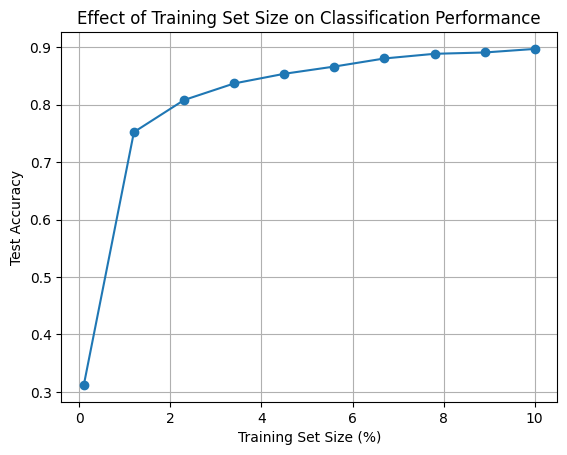

In [ ]:
def plot_accuracy(train_sizes, test_accuracies):
    """
    Plot the accuracy as a function of training set size.

    Args:
        train_sizes (list): List of training set sizes in percentages.
        test_accuracies (list): List of corresponding test accuracies.

    Returns:
        None
    """
    try:
        plt.plot(train_sizes * 100, test_accuracies, marker='o')
        plt.xlabel('Training Set Size (%)')
        plt.ylabel('Test Accuracy')
        plt.title('Effect of Training Set Size on Classification Performance')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print("An error occurred while plotting accuracy:", str(e))


plot_accuracy(subset_sizes, accuracies)


Here as we are increasing the traiing set size the accuracy is improving, I have some things in mind,
* We can get more accuracy by training for some more epochs.
* At first place it is obious, as the more data we have our model can generalise well
* There might be a problem, as the model is again and again running on same data for testing might be it has learned some features, that can be checked by seeing the training and test losses for checking the overfitting